### Cab-Driver Agent

In [1]:
# Importing libraries
from Env import CabDriver_New
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
import math
import random
from itertools import permutations

# for plotting graphs
import matplotlib.pyplot as plt

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam



### 1. Load  Time Matrix

In [2]:
# Loading the time matrix provided
import os
print(os.listdir(r"D:\UPGRAD\reinforcement learning\group project\chnaged\Cab-Driver-Assignment"))
Time_matrix1 = np.load(r"D:\UPGRAD\reinforcement learning\group project\chnaged\Cab-Driver-Assignment\TM.npy")

['Agent_Architecture1.ipynb', 'Env.py', 'SuperCabs_car_model.h5', 'SuperCabs_model_weights.pkl', 'TM.npy']


#### Check what the max, min and mean time values are. This will help us in defining the 'next_step' function in the Environment.

In [3]:
print(type(Time_matrix1))
print(Time_matrix1.max())
print(Time_matrix1.min())
print(Time_matrix1.mean())
print(Time_matrix1.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


#### Since the max time is 11 hours between any 2 points, the next state of the cab driver may increase at most by  1 day.

### 2. Agent Class




In [4]:
class DQNAgent_New:
    def __init__(self, state_size, action_size):
        
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005 #for 15k episodes
        self.epsilon_min = 0.00001
        
        self.batch_size = 32

        #  replay memory using deque
        self.memory = deque(maxlen=2000)

        #  the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        #  main model and target model
        self.model = self.build_model_new()

    # approximate Q function using Neural Network
    def build_model_new(self):
        """
        Function that takes in the agent and constructs the network
        to train it
        @return model
        @params agent
        """
        input_shape = self.state_size
        model_new = Sequential()
        model_new.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model_new.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model_new.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model_new.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model_new.summary
        return model_new

    def get_action_new(self, state, possible_actions_index, actions):
        """
        get action in a state according to an epsilon-greedy approach
        possible_actions_index, actions are the 'ride requests' that teh driver got.
        """        
            
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
          
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)
            q_value = self.model.predict(state)
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]
            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample_new(self, state, action_index, reward, next_state, done):
        """appends the new agent run output to replay buffer"""
        self.memory.append((state, action_index, reward, next_state, done))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model_new(self):
        """ 
        Function to train the model on eacg step run.
        Picks the random memory events according to batch size and 
        runs it through the network to train it.
        """
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialize two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.model.predict(update_output)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states_new(self):
        # Using the model to predict the q_value of the state 
        q_value1 = self.model.predict(self.track_state)
        
        print("States_tracked value {0}. >>>>>>>".format(q_value1[0][2]))
        
        # get the q_value of the action index 
        self.states_tracked.append(q_value1[0][2])
        
    def save(self, name):
        self.model.save(name)
        


### 3. DQN block

In [5]:
episode_time = 24*30 #30 days before which car has to be recharged
#n_episodes = 15000
number_of_episodes = 1000
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver_New()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent_New(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []

### 4. Run the episodes, build up replay buffer and train the model.
### Note:
#### 
#### The init state is randomly picked from the state space for each episode

In [6]:
start_time = time.time()
score_tracked = []

for episode in range(number_of_episodes):

    done = False
    score = 0
    track_reward = False

    # reset at the start of each episode
    env = CabDriver_New()
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init

    # Total time driver rode in this episode
    total_time = 0  
    while not done:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action_new(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix1)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
        
            done = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample_new(state, action, reward, next_state, done)
            # 6. Train the model by calling function agent.train_model
            agent.train_model_new()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode {0}:::, reward {1}:::, memory_length {2}:::, epsilon {3} total_time {4}:::".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    # Saving the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states_new()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}:::".format(episode))
        agent.save(name="SuperCabs_car_model_project.h5")

    
elapsed_time1 = time.time() - start_time
print(elapsed_time1)

Saving Model 0:::
States_tracked value 0.0. >>>>>>>
episode 9:::, reward 57.0:::, memory_length 1402:::, epsilon 0.9955001547284723 total_time 725.0:::
States_tracked value 0.0. >>>>>>>
States_tracked value 0.0. >>>>>>>
episode 19:::, reward -257.0:::, memory_length 2000:::, epsilon 0.9905350769930761 total_time 724.0:::
States_tracked value 0.0. >>>>>>>
States_tracked value 0.0. >>>>>>>
episode 29:::, reward -315.0:::, memory_length 2000:::, epsilon 0.9855947626861951 total_time 722.0:::
States_tracked value 0.0. >>>>>>>
States_tracked value 0.0. >>>>>>>
episode 39:::, reward -68.0:::, memory_length 2000:::, epsilon 0.9806790882997144 total_time 727.0:::
States_tracked value 0.0. >>>>>>>
States_tracked value 0.0. >>>>>>>
episode 49:::, reward -210.0:::, memory_length 2000:::, epsilon 0.9757879309415182 total_time 722.0:::
States_tracked value 0.0. >>>>>>>
States_tracked value 0.0. >>>>>>>
episode 59:::, reward -319.0:::, memory_length 2000:::, epsilon 0.9709211683324178 total_time 727

In [7]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [8]:
save_obj(agent.states_tracked,"SuperCabs_model_weights_Project")

### Tracking Convergence

In [9]:
agent.states_tracked

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [10]:
state_tracked_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

### 5. Plot the Q-Value convergence for state action pairs

C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  after removing the cwd from sys.path.


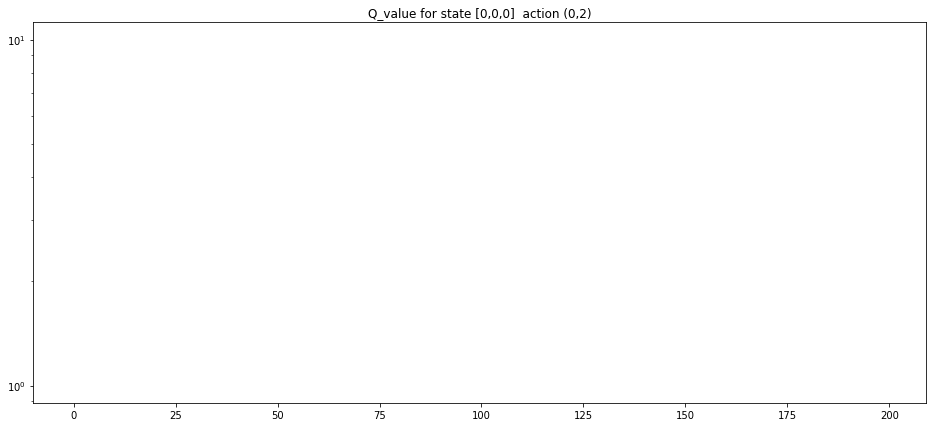

In [11]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis1 = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis1,np.asarray(agent.states_tracked))
plt.show()

#### Using log scale because the initial q_values are way to high compared to the steady state value (around 600)

### 6. Track rewards per episode.

In [12]:
score_tracked_sample1 = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

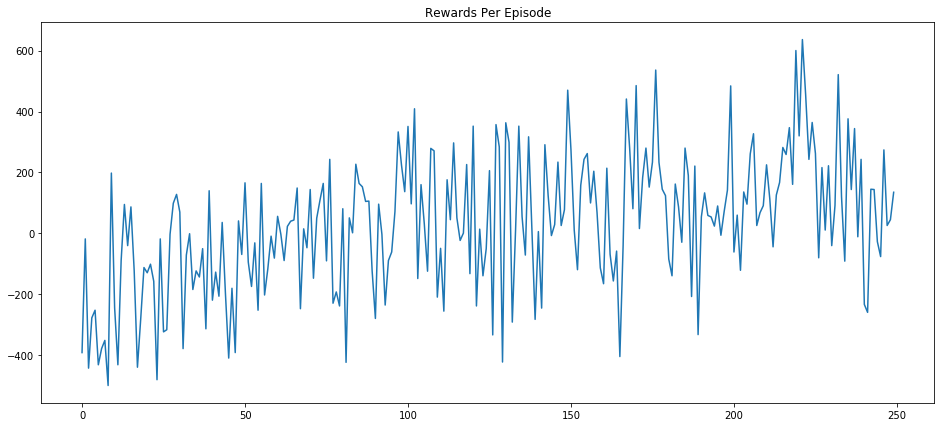

In [13]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards Per Episode')
xaxis1 = np.asarray(range(0, len(score_tracked_sample1)))
plt.plot(xaxis1,np.asarray(score_tracked_sample1))
plt.show()

###  Since the initial state is picked to be random for each episode, some initial states may be less rewarding than others inherently regardless of the model quality.

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Trying to build a similar epsilon-decay function for your model.
</div>

In [14]:
import numpy as np
time1 = np.arange(0,15000)
epsilon = []
for i in range(0,15000):
    epsilon.append((1 - 0.00001) * np.exp(-0.0005 * i))

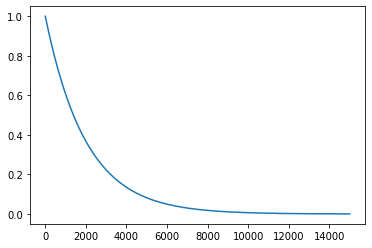

In [15]:
import matplotlib.pyplot as plt
plt.plot(time1, epsilon)
plt.show()